In [4]:
import pandas as pd
import seaborn as sns
import numpy as np
import os


DATA_DIR = '../data/seattle'

df_calendar = pd.read_parquet(os.path.join(DATA_DIR, 'calendar.parquet'))
df_listings = pd.read_parquet(os.path.join(DATA_DIR, 'listings.parquet'))
df_reviews = pd.read_parquet(os.path.join(DATA_DIR, 'reviews.parquet'))

display('df_calendar',df_calendar.head(2))
display('df_listings',df_listings.head(2)) 
display('df_reviews',df_reviews.head(2))

'df_calendar'

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,9419,2024-12-23,f,$62.00,NaN,2,90
1,9419,2024-12-24,f,$62.00,NaN,2,90


'df_listings'

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,6606,https://www.airbnb.com/rooms/6606,20241223022600,2024-12-23,city scrape,"Fab, private seattle urban cottage!","This tiny cottage is only 15x10, but it has ev...","A peaceful yet highly accessible neighborhood,...",https://a0.muscache.com/pictures/45742/21116d7...,14942,...,4.77,4.88,4.57,str-opli-19-002622,f,2,2,0,0,0.86
1,9419,https://www.airbnb.com/rooms/9419,20241223022600,2024-12-23,city scrape,Glorious sun room w/ memory foambed,This beautiful double room features sun filled...,"Lots of restaurants (see our guide book) bars,...",https://a0.muscache.com/pictures/56645186/e5fb...,30559,...,4.89,4.68,4.67,Exempt,f,11,0,11,0,1.19


'df_reviews'

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,9419,71022,2010-07-30,166478,Beth,"If you love art, animals, and yoga, this is th..."
1,9419,83099,2010-08-23,165949,Erica,I only overnighted here but I loved the offbea...


In [4]:
!which python # Should be /Users/aus10powell/opt/anaconda3/bin/python

/Users/aus10powell/Documents/Projects/AirRanker/venv/bin/python


### Reviews

Reviews per user summary statistics:
count    454082.000000
mean          1.159665
std           0.685782
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          73.000000
Name: count, dtype: float64

Percentage of users by review count:
Users with exactly 1 review(s): 89.8%
Users with exactly 2 review(s): 7.4%
Users with exactly 3 review(s): 1.6%
Users with exactly 5 review(s): 0.3%
Users with exactly 10 review(s): 0.0%

Percentage of users with only 1 review: 89.8%


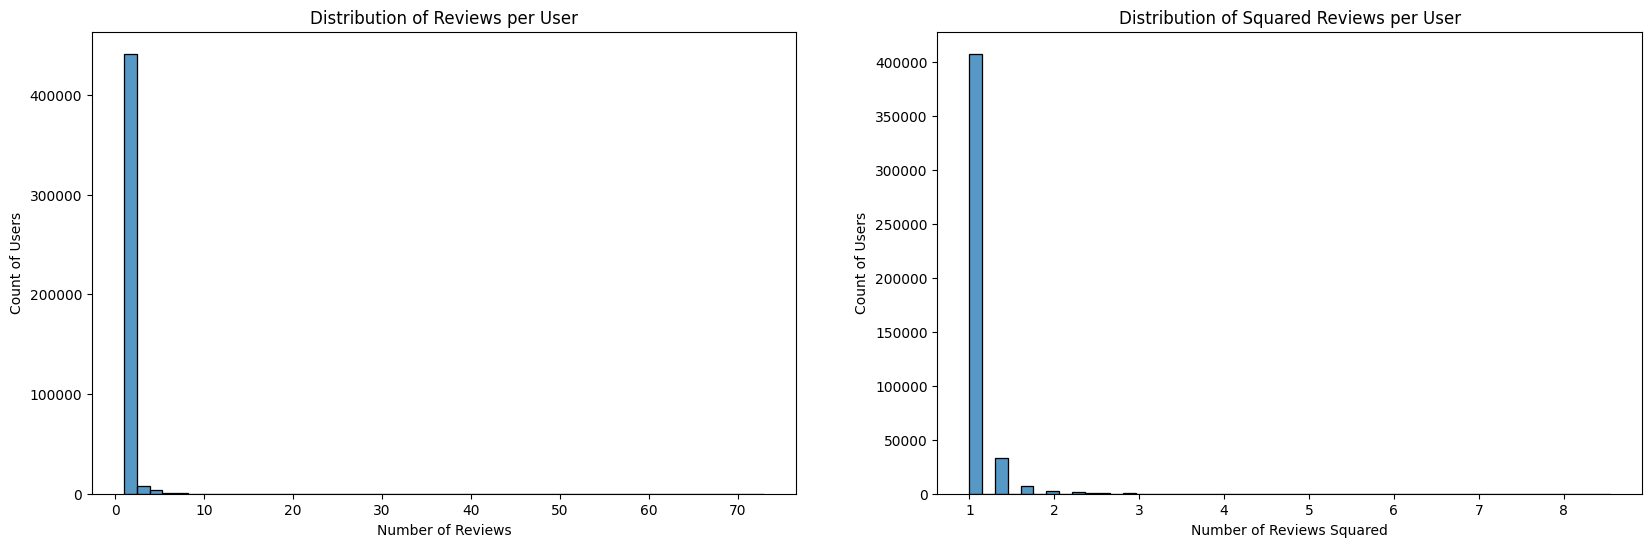

In [14]:
# Number of reviews per user distribution
# Calculate reviews per user
reviews_per_user = df_reviews['reviewer_id'].value_counts()

# Create distribution plots
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 6))

# Original distribution
plt.subplot(1, 2, 1)
sns.histplot(data=reviews_per_user, bins=50)
plt.title('Distribution of Reviews per User')
plt.xlabel('Number of Reviews')
plt.ylabel('Count of Users')

# Squared distribution 
plt.subplot(1, 2, 2)
sns.histplot(data=np.sqrt(reviews_per_user), bins=50)
plt.title('Distribution of Squared Reviews per User')
plt.xlabel('Number of Reviews Squared')
plt.ylabel('Count of Users')

# Print summary statistics
print("Reviews per user summary statistics:")
print(reviews_per_user.describe())

# Show percentage of users with different review counts
print("\nPercentage of users by review count:")
for n in [1, 2, 3, 5, 10]:
    pct = (reviews_per_user == n).mean() * 100
    print(f"Users with exactly {n} review(s): {pct:.1f}%")

pct_single = (reviews_per_user == 1).mean() * 100
print(f"\nPercentage of users with only 1 review: {pct_single:.1f}%")


For Seattle listings
The average of all listing ratings is: 4.81
The median of all listing ratings is: 4.90


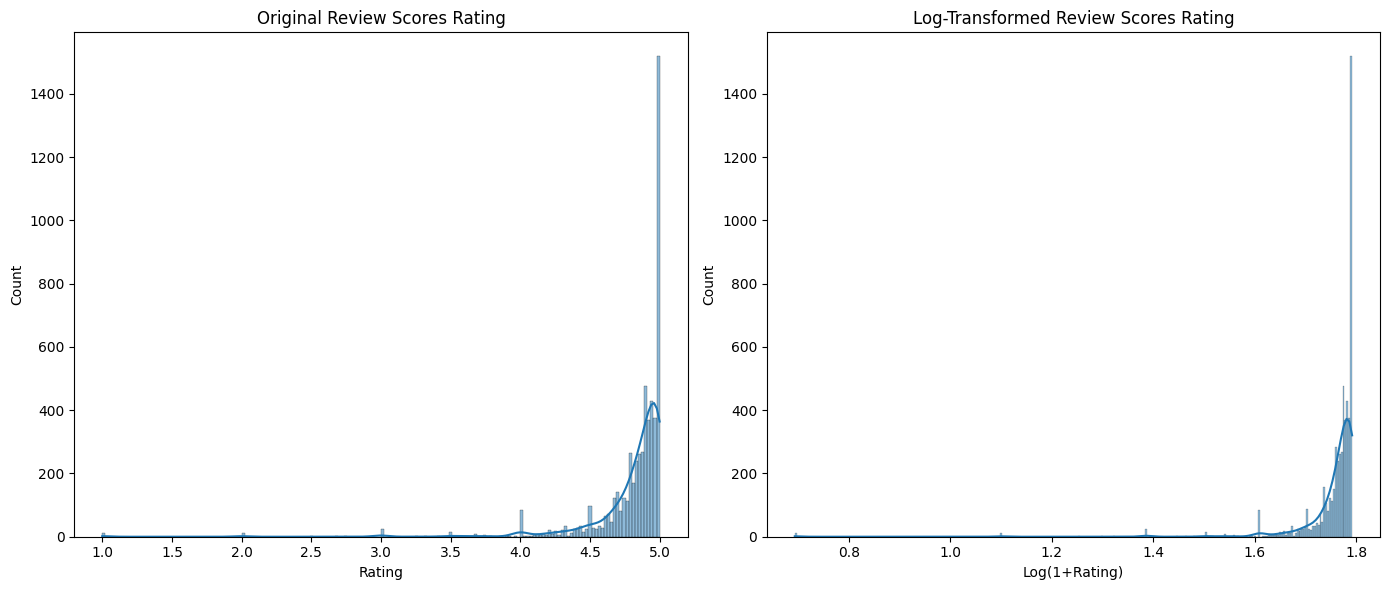

In [23]:
print("For Seattle listings")
# Calculate the average of the average ratings
average_rating = df_listings['review_scores_rating'].mean()

print(f"The average of all listing ratings is: {average_rating:.2f}")

median_rating = df_listings['review_scores_rating'].median()

print(f"The median of all listing ratings is: {median_rating:.2f}")


# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot the original distribution
sns.histplot(df_listings['review_scores_rating'], kde=True, ax=axes[0])
axes[0].set_title('Original Review Scores Rating')
axes[0].set_xlabel('Rating')

# Create the logged version (adding a small constant to handle zeros if present)
# Using log1p (log(1+x)) which is a common transformation to handle zeros
logged_ratings = np.log1p(df_listings['review_scores_rating'])
sns.histplot(logged_ratings, kde=True, ax=axes[1])
axes[1].set_title('Log-Transformed Review Scores Rating')
axes[1].set_xlabel('Log(1+Rating)')

plt.tight_layout()
plt.show()



/var/folders/qq/gdppvj912kv3ds7_xnf0q_fc0000gn/T/ipykernel_6690/2325313049.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='sentiment_category', data=df_reviews,
/var/folders/qq/gdppvj912kv3ds7_xnf0q_fc0000gn/T/ipykernel_6690/2325313049.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='sentiment_category', y='sentiment_score', data=df_reviews,


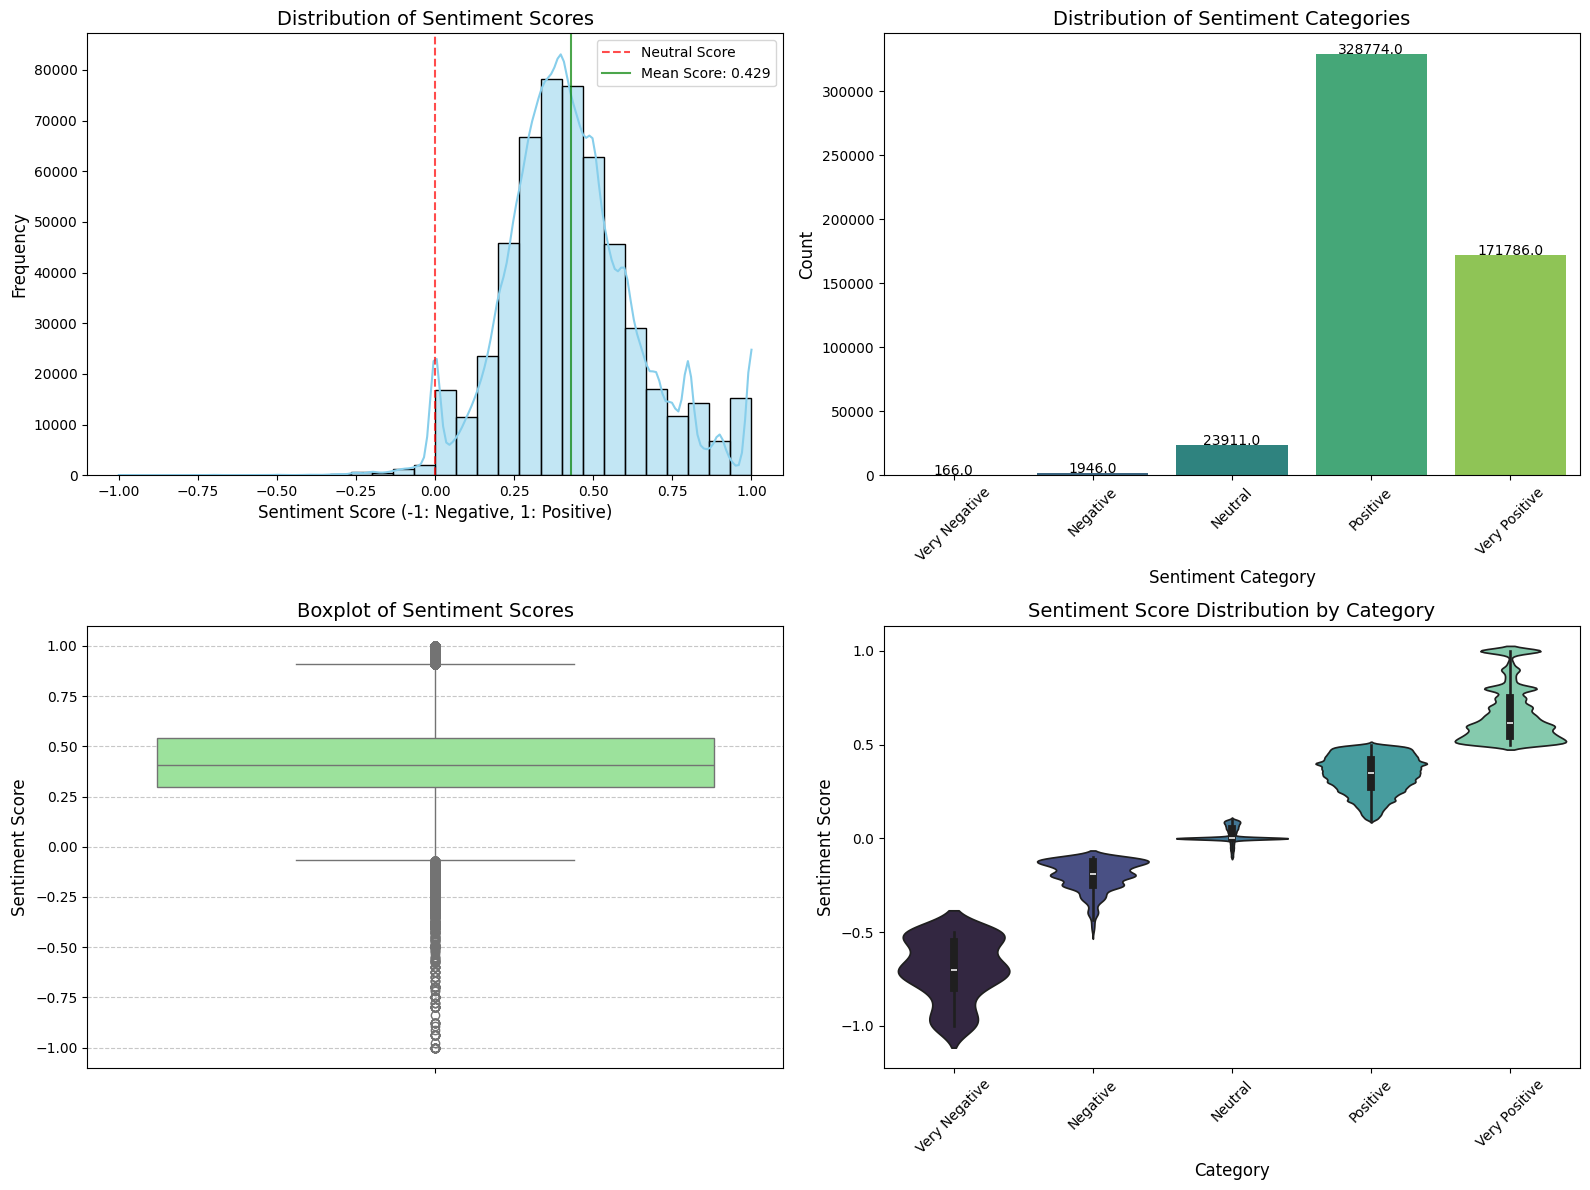


Summary Statistics of Sentiment Scores:


count    526583.000000
mean          0.429306
std           0.213419
min          -1.000000
25%           0.298192
50%           0.409524
75%           0.542557
max           1.000000
Name: sentiment_score, dtype: float64


Sentiment Category Distribution:


,Count,Percentage (%)
sentiment_category,,
Very Negative,166,0.03
Negative,1946,0.37
Neutral,23911,4.54
Positive,328774,62.44
Very Positive,171786,32.62



Example Reviews by Sentiment Category:

Very Negative (Score: -1.000):
vacasa canceled my reservation  within an hour of check in time, and wouldn’t communicate with me. they have terrible customer service and i won’t ever be using them again.

Negative (Score: -0.156):
We had two consecutive rental periods. Please see my other review. Bottom line; a winner!

Neutral (Score: 0.000):
what a great,unique stay.

Positive (Score: 0.450):
It was a great stay. The building is a bit old but the apartment seems renewed and in perfect conditions. Plus it has a great location. There’s a market across the street, and coffee/restaurants down ...

Very Positive (Score: 0.608):
Great place and super close to everything!


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from textblob import TextBlob
from tqdm import tqdm


# First, make sure tqdm is installed
# !pip install tqdm

# Enable tqdm to work with pandas
tqdm.pandas()

# Function to get sentiment score for a text
def get_sentiment_score(text):
    if isinstance(text, str):
        analysis = TextBlob(text)
        # TextBlob's sentiment polarity ranges from -1 (negative) to 1 (positive)
        return analysis.sentiment.polarity
    return 0  # Return neutral sentiment for non-string or empty values

# Apply sentiment analysis to all comments with progress bar
print("Analyzing sentiment of comments...")
df_reviews['sentiment_score'] = df_reviews['comments'].progress_apply(get_sentiment_score)

# Create discretized sentiment categories
def categorize_sentiment(score):
    if score <= -0.5:
        return "Very Negative"
    elif score <= -0.1:
        return "Negative"
    elif score < 0.1:
        return "Neutral"
    elif score < 0.5:
        return "Positive"
    else:
        return "Very Positive"

df_reviews['sentiment_category'] = df_reviews['sentiment_score'].apply(categorize_sentiment)


# Set up the matplotlib figure
plt.figure(figsize=(16, 12))

# Create a subplot grid: 2 rows, 2 columns
plt.subplot(2, 2, 1)
# Plot 1: Distribution of sentiment scores as a histogram with KDE
sns.histplot(df_reviews['sentiment_score'], kde=True, bins=30, color='skyblue')
plt.title('Distribution of Sentiment Scores', fontsize=14)
plt.xlabel('Sentiment Score (-1: Negative, 1: Positive)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Neutral Score')
plt.axvline(x=np.mean(df_reviews['sentiment_score']), color='green', linestyle='-', alpha=0.7, 
            label=f'Mean Score: {np.mean(df_reviews["sentiment_score"]):.3f}')
plt.legend()

plt.subplot(2, 2, 2)
# Plot 2: Count plot of sentiment categories
order = ["Very Negative", "Negative", "Neutral", "Positive", "Very Positive"]
ax = sns.countplot(x='sentiment_category', data=df_reviews, 
                  order=order, palette='viridis')
plt.title('Distribution of Sentiment Categories', fontsize=14)
plt.xlabel('Sentiment Category', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
# Add count labels
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', 
                (p.get_x() + p.get_width() / 2., p.get_height() + 20),
                ha='center', fontsize=10)

plt.subplot(2, 2, 3)
# Plot 3: Boxplot of sentiment scores
sns.boxplot(y='sentiment_score', data=df_reviews, color='lightgreen')
plt.title('Boxplot of Sentiment Scores', fontsize=14)
plt.ylabel('Sentiment Score', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(2, 2, 4)
# Plot 4: Violin plot of sentiment scores by category
sns.violinplot(x='sentiment_category', y='sentiment_score', data=df_reviews, 
              order=order, palette='mako')
plt.title('Sentiment Score Distribution by Category', fontsize=14)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Sentiment Score', fontsize=12)
plt.xticks(rotation=45)

# Adjust layout
plt.tight_layout()
plt.savefig('sentiment_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\nSummary Statistics of Sentiment Scores:")
display(df_reviews['sentiment_score'].describe())

# Show percentage distribution of sentiment categories
sentiment_counts = df_reviews['sentiment_category'].value_counts().sort_index()
sentiment_percentages = 100 * sentiment_counts / len(df_reviews)
sentiment_distribution = pd.DataFrame({
    'Count': sentiment_counts,
    'Percentage (%)': sentiment_percentages.round(2)
})
# Sort by the predefined order
sentiment_distribution = sentiment_distribution.reindex(order)
print("\nSentiment Category Distribution:")
display(sentiment_distribution)

# Find examples of reviews in each category
print("\nExample Reviews by Sentiment Category:")
for category in order:
    category_examples = df_reviews[df_reviews['sentiment_category'] == category].sample(min(1, sum(df_reviews['sentiment_category'] == category)))
    if not category_examples.empty:
        example = category_examples.iloc[0]
        print(f"\n{category} (Score: {example['sentiment_score']:.3f}):")
        comment_preview = example['comments'][:200] + '...' if len(example['comments']) > 200 else example['comments']
        print(comment_preview)